This is an analysis of the 2025 clock data. The data collected on 2025-03-13 has a subfolder with data that seems to be formatted differently from the rest. 

In [20]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import math 

################################################################################
#############################  Load data #######################################
################################################################################

## comb data (note last two columns swapped from earlier code, also not including header varb in function) 
def open_ErYb_data(data_path):
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Yb_ErYb", "fb_Al_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    data.index = range(len(data))
 
    return data[list(types.keys())]

## Al shift data 
def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data

## Sr shift data (note header is 24 lines) 
def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=24, delimiter="\t", dtype={1: str}, engine="python")

    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 ## Yb shift data (note use of raw string deliminator is necessary here probably due to data coming from a json config file or something about the string construction of the data file)  
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t",  dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
## Open maser correction file 
def open_maser_correction(datapath):
    data = pd.read_csv(datapath, header=1, delimiter=",", dtype={1: str}, engine="python")
 
    data.columns = ["date", "maser_offset"]
 
    data["date"] = data["date"].str.split("-").str.join("")
    data["maser_offset"] = data["maser_offset"].apply(float)
 
    return data

In [21]:

## Dates for which we have complete 2025 data. 
day_index = 2
#days = [20250116, 20250124, 20250204, 20250206, 20250227, 20250228, 20250304, 20250306, 20250307, 20250313, 20250318, 20250320, 20250321]
days = [20250116, 20250124, 20250204, 20250227, 20250304, 20250307, 20250318]
days = list(map(str, days))
path = "/Users/smt3/Documents/GitHub/2025 clock comparison data/"

maser_corrections = open_maser_correction(path + "daily maser offsets.csv")
#print(maser_corrections["date"])

In [22]:

# load comb data
data_ErYb = open_ErYb_data(path + days[day_index] + "/" + days[day_index] + "_Deglitched_ErYb_only.dat")
 
# load Al shift data 
shift_data_Al = open_shiftfile_Al(path + days[day_index] + "/" + days[day_index] + "_Alp_Freq_Shifts_ErYb.dat")

# load Sr shift data 
shift_data_Sr = open_shiftfile_Sr(path + days[day_index] + "/" + days[day_index] + "_clock_lock0.dat")

# load Yb shift data
shift_data_Yb = open_shiftfile_Yb(path + days[day_index] + "/YbI_1_rerun.txt")

In [23]:
################################################################################
#############  Functions to find optical frequencies with comb equation ########
################################################################################
 
# frequency for Al+ clock
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

# frequency for Sr clock 
def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))

# freuency for Yb clock
def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"] 


################################################################################
###############  get optical frequencies #############################
################################################################################
 
compute_nuAl_ErYb(data_ErYb)
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb) 

################################################################################
#########################  Data Processing #####################################
################################################################################

## Extract only "IS_GOOD" data for analysis 
good_condition_al = shift_data_Al["IS_GOOD"] == 1
shift_data_Al_good = shift_data_Al[good_condition_al].reset_index(drop=True)
good_condition_sr = shift_data_Sr["IS_GOOD"] == 1
shift_data_Sr_good = shift_data_Sr[good_condition_sr].reset_index(drop=True)
good_condition_yb = shift_data_Yb["IS_GOOD"] == 1
shift_data_Yb_good = shift_data_Yb[good_condition_yb].reset_index(drop=True)

common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

print("Missing Al comb nu: ", nuAl.isna().sum())
print("Missing Sr comb nu: ", nuSr.isna().sum())
print("Missing Yb comb nu: ", nuYb.isna().sum())

# ## TODO: generalize 
# is_na = nuYb.isna() # try for each clock 
# max_streak = current_streak = 0
# for val in is_na:
#     if val:
#         current_streak += 1
#         max_streak = max(max_streak, current_streak)
#     else:
#         current_streak = 0
# print("Total NaNs:", is_na.sum())
# print("Longest sequence of NaNs:", max_streak, '\n')

Missing Al comb nu:  126
Missing Sr comb nu:  121
Missing Yb comb nu:  712


In [24]:
len_comb = len(common_mjd) 
len_Al = len(shift_data_Al_good['shift'])        
len_Sr = len(shift_data_Sr_good['shift'])        
len_Yb = len(shift_data_Yb_good['shift'])
# end_comb_inx = len_comb - 1 - max_streak #TODO: generalize 

print("nuAl, nuSr, and nuYb start and end MJD: [", common_mjd[0], ', ', common_mjd[len_comb-1], ']')
print("Al good shift start  and end MJD: [", shift_data_Al_good['MJD'][0], ', ', shift_data_Al_good['MJD'][len_Al-1], ']')
print("Sr good shift start  and end MJD: [", shift_data_Sr_good['MJD'][0], ', ', shift_data_Sr_good['MJD'][len_Sr-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'][0], ', ', shift_data_Yb_good['MJD'][len_Yb-1], ']')

starts = [common_mjd[0], shift_data_Al_good['MJD'][0], shift_data_Sr_good['MJD'][0], shift_data_Yb_good['MJD'][0]] 
ends = [common_mjd[len_comb-1], shift_data_Al_good['MJD'][len_Al-1], shift_data_Sr_good['MJD'][len_Sr-1], shift_data_Yb_good['MJD'][len_Yb-1]] 


nuAl, nuSr, and nuYb start and end MJD: [ 60710.776975 ,  60711.084524 ]
Al good shift start  and end MJD: [ 60710.7777199 ,  60711.001331 ]
Sr good shift start  and end MJD: [ 60710.774207885224 ,  60711.00208831321 ]
Yb good shift start and end MJD: [ 60710.77930638 ,  60711.03137538 ]


In [25]:
################################################################################
#############################  Extract overlapping data  #######################
################################################################################

last_start_time = max(starts)
first_end_time = min(ends)

#function to extract element as close to target as possible w/out going over
#if first element of data is larger or equal to the target, returns the first data index 
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data[inx] < target:
            inx += 1
        else:
            return inx  

#function to extract element as close to target as possible w/out going under 
#if last element of data is smaller or equal to the target, returns the last data index 
def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data[len(data)-inx] > target:
            inx += 1
        else:
            return len(data)-inx 


comb = pd.DataFrame()
comb_start = ub_extract(target = last_start_time, data = common_mjd)  
comb_end = lb_extract(target = first_end_time, data = common_mjd) 
comb["MJD"] = common_mjd[comb_start:comb_end] 
comb["nuAl"] = nuAl[comb_start:comb_end]
comb['nuAl'] = pd.to_numeric(comb['nuAl'], errors='coerce')
comb["nuSr"] = nuSr[comb_start:comb_end]
comb['nuSr'] = pd.to_numeric(comb['nuSr'], errors='coerce')
comb["nuYb"] = nuYb[comb_start:comb_end]
comb['nuYb'] = pd.to_numeric(comb['nuYb'], errors='coerce')

al_start = ub_extract(target = last_start_time, data = shift_data_Al_good["MJD"])
al_end = lb_extract(target = first_end_time, data = shift_data_Al_good["MJD"])  
shift_data_Al = shift_data_Al_good[al_start:al_end] 

sr_start = ub_extract(target = last_start_time, data = shift_data_Sr_good["MJD"])
sr_end = lb_extract(target = first_end_time, data = shift_data_Sr_good["MJD"])  
shift_data_Sr = shift_data_Sr_good[sr_start:sr_end]

yb_start = ub_extract(target = last_start_time, data = shift_data_Yb_good["MJD"])
yb_end = lb_extract(target = first_end_time, data = shift_data_Yb_good["MJD"])  
shift_data_Yb = shift_data_Yb_good[yb_start:yb_end]


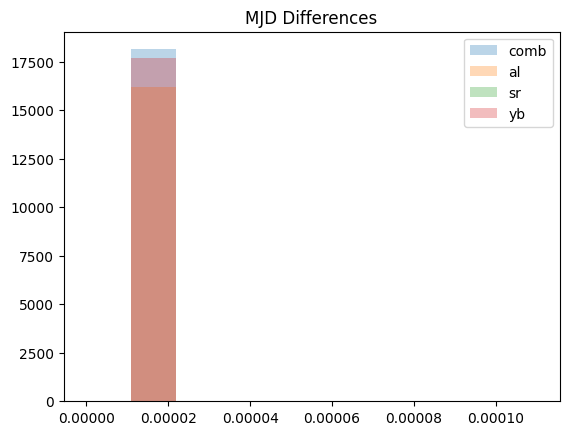

In [26]:

comb = comb.reset_index(drop=True)  
shift_data_Al = shift_data_Al.reset_index(drop=True)
shift_data_Sr = shift_data_Sr.reset_index(drop=True)
shift_data_Yb = shift_data_Yb.reset_index(drop=True)

## Create data frame of differences in MDJ values for each series 
data = {
    "comb": comb.MJD.diff(),
    "al": shift_data_Al.MJD.diff(),
    "sr": shift_data_Sr.MJD.diff(),
    "yb": shift_data_Yb.MJD.diff()
} 
mjd_diff = pd.DataFrame(data)
#print(mjd_diff.head(5))

plt.hist(data['comb'], alpha=0.3, range =[0, 0.00011], 
          label='comb') 
plt.hist(data['al'], alpha=0.3, range =[0, 0.00011], 
          label='al') 
plt.hist(data['sr'], alpha=0.3, range =[0, 0.00011],
          label='sr') 
plt.hist(data['yb'], alpha=0.3, range =[0, 0.00011],
          label='yb') 
plt.legend(loc='upper right') 
plt.title('MJD Differences') 
plt.show()

In [71]:
# Ratios from 2020
YbSrRatio2020 = Decimal("1.2075070393433378482") 
AlYbRatio2020 = Decimal("2.162887127516663703")
AlSrRatio2020 = Decimal("2.611701431781463025")
 
# frequency corrections 
correction_condition = days[day_index] == maser_corrections["date"]
masercorrection = maser_corrections[correction_condition]["maser_offset"].apply(Decimal)

GR_shift_Al = Decimal("-8.114e-16") ##update? ##TODO: update these values based on Drive folder, ask Mason Marshall about missing Al+ GR shift
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_Sr = Decimal("10.660e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")

total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection
total_correction_Sr = Decimal("1") + GR_shift_Sr + GR_shift_sea_level + masercorrection
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection


### Overlapping AVAR function 
## Also see: https://pypi.org/project/AllanTools/
def overlapping_avar_fn(y, m): #note y must be a scalar 
    M = len(y)

    if M < 2 * m:
        raise ValueError(f"Length of input (M={M}) must be at least 2 * m (2 * {m} = {2 * m})")

    if any(isinstance(v, Decimal) and v.is_nan() for v in y): #note: is_nan() is used to accomodate list data of type Decimal
        raise ValueError("Input y contains NaN values.")
    
    if m <= 0:
        raise ValueError("m must be a positive integer")

    outer_sum = 0

    for j in range(0, M - 2 * m + 1):
        inner_sum = 0
        for i in range(j, j + m):
            inner_sum += y[i + m] - y[i]
        outer_sum += inner_sum ** 2

    result = outer_sum / (2 * m**2 * (M - 2 * m + 1))
    return result


In [72]:
################################################################################
#############################  Interpolation  ##################################
################################################################################ 
# same approach as in pandas_interpolation_nick.py

shift_Al_tmp = shift_data_Al["shift"].interpolate(method="linear")
shift_Sr_tmp = shift_data_Sr["shift"].interpolate(method="linear")
shift_Yb_tmp = shift_data_Yb["shift"].interpolate(method="linear")

shiftAl = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_Al_tmp)
shiftSr = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_Sr_tmp)
shiftYb = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_Yb_tmp)

# change data type to high-precision Decimal
nuAl = [Decimal(i) for i in comb['nuAl']]
nuSr = [Decimal(i) for i in comb['nuSr']]
nuYb = [Decimal(i) for i in comb['nuYb']]
shiftAl = [Decimal(i) for i in shiftAl]
shiftSr = [Decimal(i) for i in shiftSr]
shiftYb = [Decimal(i) for i in shiftYb]


# add comb frequencies and clock shift files
frequency_Al_ErYb = [(i + j) * total_correction_Al for i,j in zip(nuAl, shiftAl)]
frequency_Sr_ErYb = [(i + j) * total_correction_Sr for i,j in zip(nuSr, shiftSr)]
frequency_Yb_ErYb = [(i + j) * total_correction_Sr for i,j in zip(nuYb, shiftYb)]

frequency_Al_ErYb = [v.iloc[0] for v in frequency_Al_ErYb] #converts a list contaiing series (of length one) into a single-Decimal-value series object so can apply avar function
frequency_Sr_ErYb = [v.iloc[0] for v in frequency_Sr_ErYb]
frequency_Yb_ErYb = [v.iloc[0] for v in frequency_Yb_ErYb]



Al+/Sr ratio offset from BACON paper -1.1859E-16
AVAR tau=5:  1.439274931497006516467005739E-33
AVAR tau=500:  3.839539037952475046430527635E-34


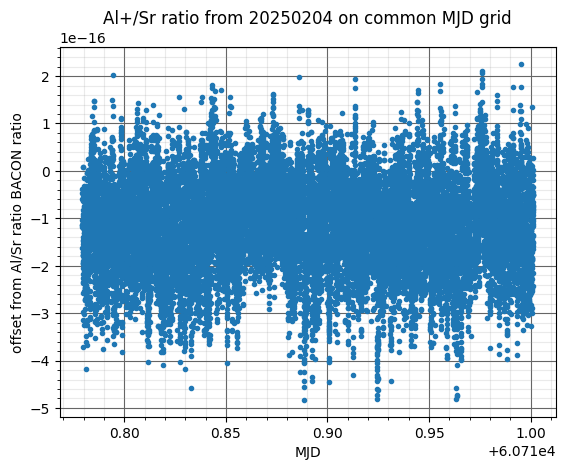

In [ ]:
################################################################################
#######################  Plotting and Summarizing ##############################
################################################################################
 
## Al/Sr ratio offset  
frequency_ratio_ErYb1 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Sr_ErYb)]

clean_frequency_ratio_ErYb1 = [
    x for x in frequency_ratio_ErYb1
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Al+/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, 500)) 
# # TODO 
# # tau = (len(frequency_ratio_ErYb1))/3 ##floor function 
# # print("AVAR tau=", tau, ": ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, tau))

plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al+/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

Yb/Sr ratio offset from BACON paper 1.7715E-15
AVAR tau=5:  2.343728386794474927680165864E-33
AVAR tau=500:  1.205633729417987208551834343E-34


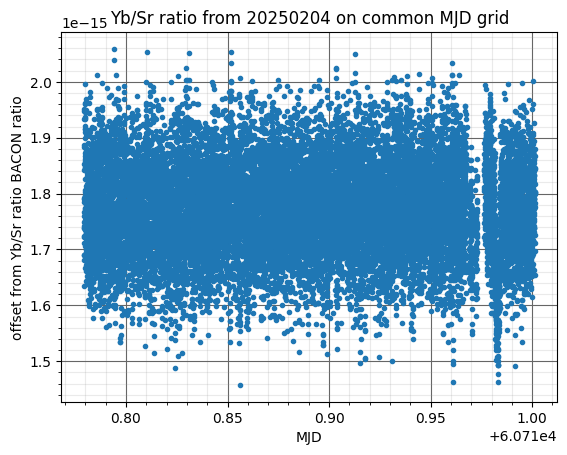

In [74]:
## Yb/Sr ratio offset  
frequency_ratio_ErYb2 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb, frequency_Sr_ErYb)]
 
clean_frequency_ratio_ErYb2 = [
    x for x in frequency_ratio_ErYb2
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Yb/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb2, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb2, 500)) 

plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

Al+/Yb ratio offset from BACON paper -1.8915E-15
AVAR tau=5:  2.567533762259006290313955294E-33
AVAR tau=500:  3.155473086961245258280357732E-34


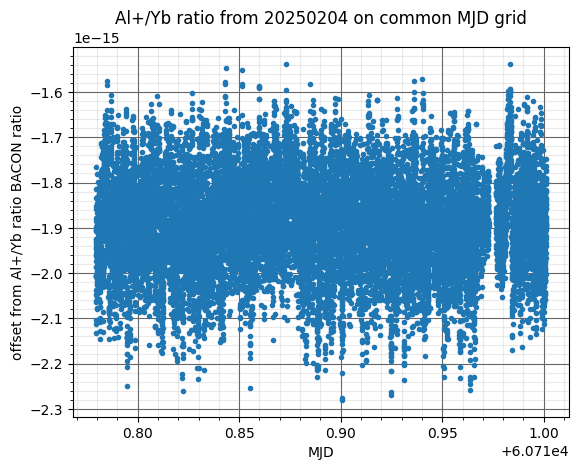

In [75]:
## Al/Yb ratio offset  
frequency_ratio_ErYb3 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Yb_ErYb)]
 
clean_frequency_ratio_ErYb3 = [
    x for x in frequency_ratio_ErYb3
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Al+/Yb ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb3, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb3, 500)) 

plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al+/Yb ratio BACON ratio")
plt.title("Al+/Yb ratio from " + days[day_index] + " on common MJD grid")
plt.show()